In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Functions import plot_df_subplots
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
from pandas.errors import SettingWithCopyWarning # Import the specific warning class

# Ignore the specific warning category
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

ImportError: cannot import name 'plot_df_subplots' from 'Functions' (c:\Users\iandh\OneDrive\Documents\ISYE 6402 Project\Functions.py)

In [ ]:
import glob
folder_path = "Additional Data/*.csv"

data_df = pd.read_csv('VehicleData-1.csv')
data_df['DATE'] = pd.to_datetime(data_df['DATE'], format='%m/%d/%y')
min_date = min(data_df['DATE'])
max_date = max(data_df['DATE'])



for file_path in glob.glob(folder_path):
    temp = pd.read_csv(file_path)
    temp['DATE'] = pd.to_datetime(temp['observation_date'])

    # Assume the second column is the value
    value_col = temp.columns[1]
    temp = temp.drop(columns= ['observation_date']).ffill()

    data_df = pd.merge(data_df, temp, on='DATE', how='left').ffill()
    
# Set date as index
data_df = data_df.set_index('DATE').sort_index()

if 'TERMCBAUTO48NS' in data_df.columns:
    data_df['TERMCBAUTO48NS'] = data_df['TERMCBAUTO48NS'].ffill()
    data_df['TERMCBAUTO48NS'] = data_df['TERMCBAUTO48NS'].bfill()

data_df['AUTOSA'] = data_df['DAUTOSA'] + data_df['FAUTOSA']


Filter to pre-covid

### VAR Expirements

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_var(var_data, test_horizon, exog_data=None):
 

    # -------------------------
    # Train/Test Split
    # -------------------------
    train_data = var_data.iloc[:-test_horizon]
    test_data  = var_data.iloc[-test_horizon:]

    if exog_data is not None:
        exog_train = exog_data.iloc[:-test_horizon]
        exog_test  = exog_data.iloc[-test_horizon:]
    else:
        exog_train = exog_test = None

    history_y = train_data.copy()
    history_exog = exog_train.copy() if exog_train is not None else None

    rolling_forecasts = []


    if exog_data is None:
        model = VAR(history_y)

        order_selection = model.select_order(maxlags=10)
        best_order = order_selection.bic 
        print(f'Selected Order: {best_order}')
        print(order_selection.summary())

    else:
        best_bic = np.inf
        order_results = []
        for p in range(0, 3):
            for q in range(0, 3):
                print(p, ',', q)
                try:
                    test_model = VARMAX(history_y, exog=history_exog, order=(p, q))
                    test_res   = test_model.fit(disp=False)

                    order_results.append({"p": p, "q": q, "bic": test_res.bic, "aic": test_res.aic})

                    if test_res.bic < best_bic:
                        best_bic = test_res.bic
                        best_order = (p, q)

                except Exception as e:
                    order_results.append({"p": p, "q": q, "bic": np.inf, "aic": np.inf})
                    print(f"VARMAX order ({p},{q}) failed with error: {e}")
                    pass

        # Convert to DataFrame summary table
        varmax_order_selection = pd.DataFrame(order_results)
        display(varmax_order_selection)
        model = VARMAX(history_y, exog=history_exog, order=best_order)

    # Rolling Forecast Loop
    for t in range(test_horizon):

        if exog_data is None:
            # --------------------
            # VAR (no exogenous)
            # --------------------
            model = VAR(history_y)
            result = model.fit(best_order, trend='n')

            yhat = result.forecast(history_y.values[-best_order:], steps=1)[0]

        else:
            # --------------------
            # VARX using VARMAX
            # --------------------
            model = VARMAX(history_y, exog=history_exog, order=best_order)

            result = model.fit(disp=False)

            next_exog = exog_test.iloc[t:t+1]

            yhat = result.forecast(steps=1, exog=next_exog).values[0]

        rolling_forecasts.append(yhat)

        # Expand history with actual next point
        next_actual_y = test_data.iloc[t:t+1]
        history_y = pd.concat([history_y, next_actual_y])

        if exog_data is not None:
            next_actual_exog = exog_test.iloc[t:t+1]
            history_exog = pd.concat([history_exog, next_actual_exog])


    forecast_df = pd.DataFrame(
        np.array(rolling_forecasts),
        index=test_data.index,
        columns=test_data.columns
    )


    metrics = {}

    for col in test_data.columns:
        actual = test_data[col]
        pred = forecast_df[col]

        rmse = mean_squared_error(actual, pred)
        mae  = mean_absolute_error(actual, pred)

        metrics[col] = {"RMSE": rmse, "MAE": mae}

    metrics_df = pd.DataFrame(metrics).T

    return {
        "metrics": metrics_df,
        "actual": test_data,
        "pred": forecast_df,
        "model": result,
        "order": best_order
    }

VAR

Selected Order: 2
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        15.85       15.87   7.620e+06       15.86
1        15.69       15.77   6.528e+06       15.72
2        15.56      15.69*   5.707e+06       15.61
3       15.52*       15.71  5.502e+06*      15.60*
4        15.53       15.77   5.538e+06       15.63
5        15.55       15.86   5.683e+06       15.67
6        15.57       15.93   5.795e+06       15.72
7        15.58       15.99   5.829e+06       15.74
8        15.59       16.06   5.910e+06       15.78
9        15.61       16.13   5.993e+06       15.82
10       15.59       16.17   5.931e+06       15.83
--------------------------------------------------
Base Difference VAR


,RMSE,MAE
Total Sales,3.154765e-01,0.454949
New Orders,1.451149e+06,837.820819


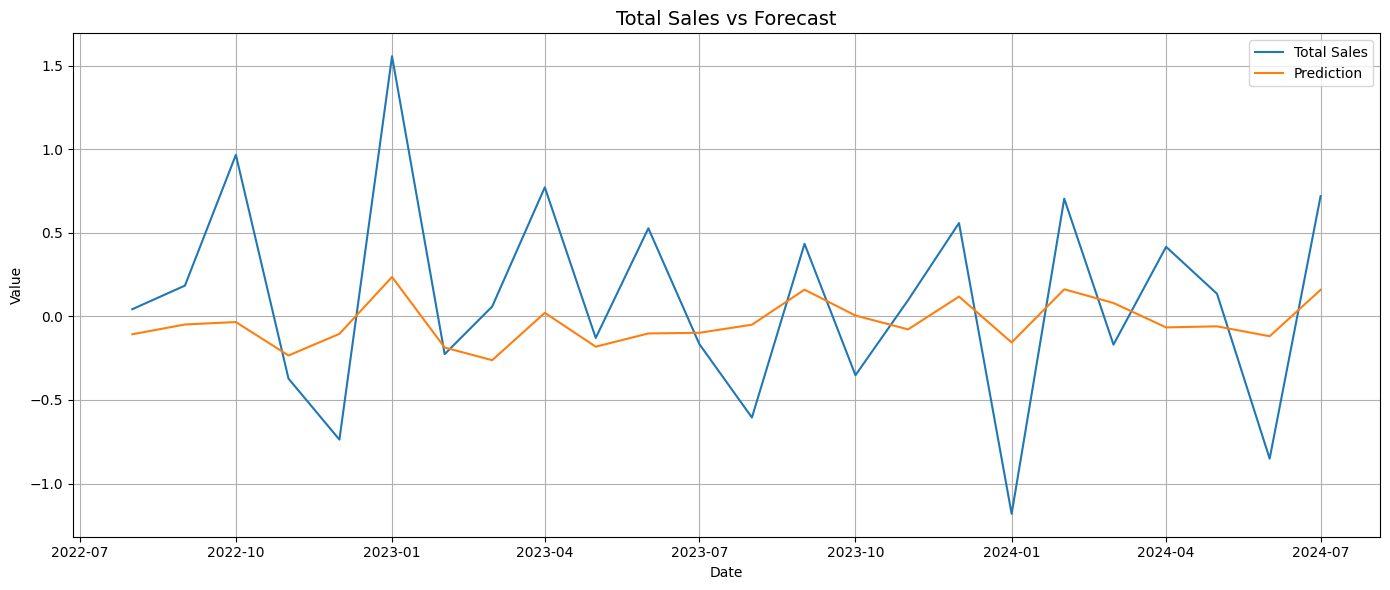

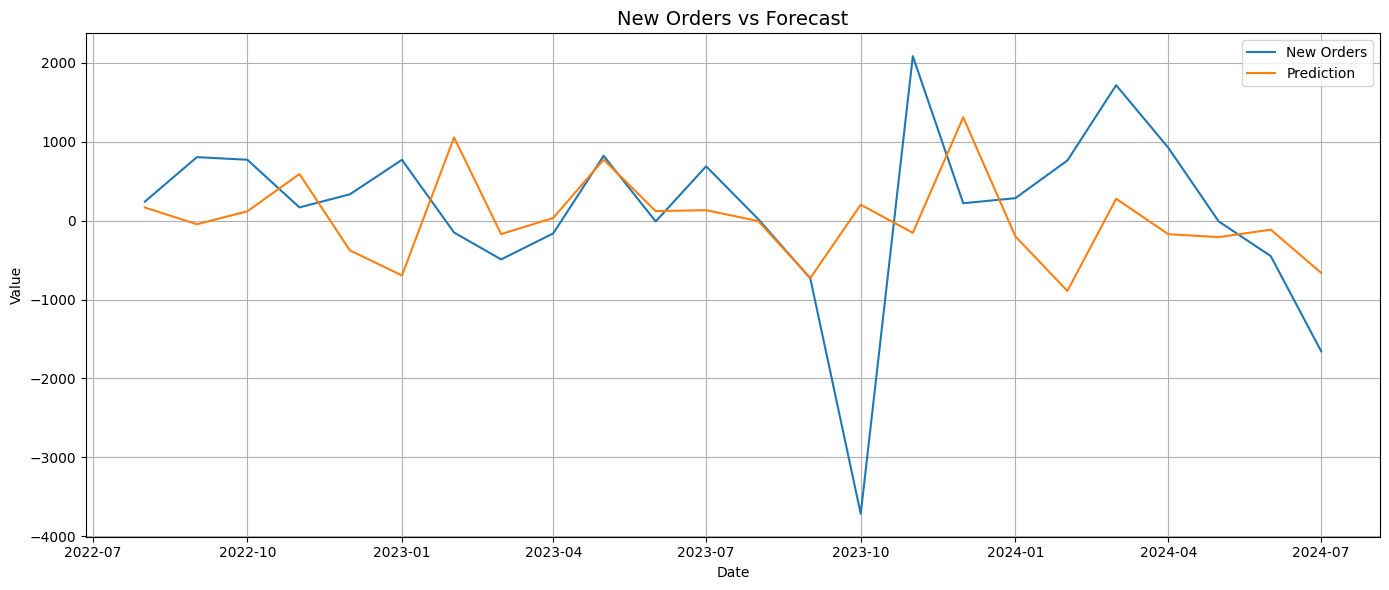

In [81]:
diff_df = filt_df.diff().dropna()
base_var = train_var(diff_df[['Total Sales', 'New Orders']], 24)
print('Base Difference VAR')
display(base_var['metrics'])
for col in ['Total Sales', 'New Orders']:
    df = pd.concat([base_var['actual'][col], base_var['pred'][col].rename('Prediction')], axis =1)
    plot_df_subplots(df, overlay =True, title = f'{col} vs Forecast')

In [87]:
params = base_var['model'].params
p_val = base_var['model'].pvalues
coef_summary = pd.concat(
    [base_var['model'].params, base_var['model'].pvalues],
    axis=1,
    keys=["coef", "p_value"]
)

split_tables = {}

for eq in base_var['model'].names:   
    df_eq = coef_summary.xs(eq, level=1, axis=1)   
    split_tables[eq] = df_eq


for eq, df in split_tables.items():
    print(f"\n=== Equation: {eq} ===\n")
    print(df)



=== Equation: Total Sales ===

                    coef   p_value
L1.Total Sales -0.228201  0.000212
L1.New Orders   0.000022  0.333626
L2.Total Sales -0.190890  0.002816
L2.New Orders  -0.000010  0.639292

=== Equation: New Orders ===

                      coef       p_value
L1.Total Sales  786.440111  6.799475e-07
L1.New Orders     0.046897  4.286381e-01
L2.Total Sales  179.790118  2.737085e-01
L2.New Orders    -0.320047  6.302701e-09


VARX

0 , 0
VARMAX order (0,0) failed with error: Invalid VARMAX(p,q) specification; at least one p,q must be greater than zero.
0 , 1
0 , 2


C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1 , 0


C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


1 , 1


C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1 , 2


C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 , 0


C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 , 1


C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 , 2


C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p,q,bic,aic
0,0,0,inf,inf
1,0,1,5463.489595,5409.568924
2,0,2,5446.512522,5378.213006
3,1,0,5465.097594,5411.176923
4,1,1,5482.345805,5414.046289
5,1,2,5464.346403,5381.668041
6,2,0,5495.081638,5426.782122
7,2,1,5508.072339,5425.393977
8,2,2,5511.807393,5414.750186


C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\iandh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\iandh\AppData\Local\Packages

Base Difference VAR


,RMSE,MAE
Total Sales,1.955709e-01,0.360465
New Orders,1.367996e+06,860.038739


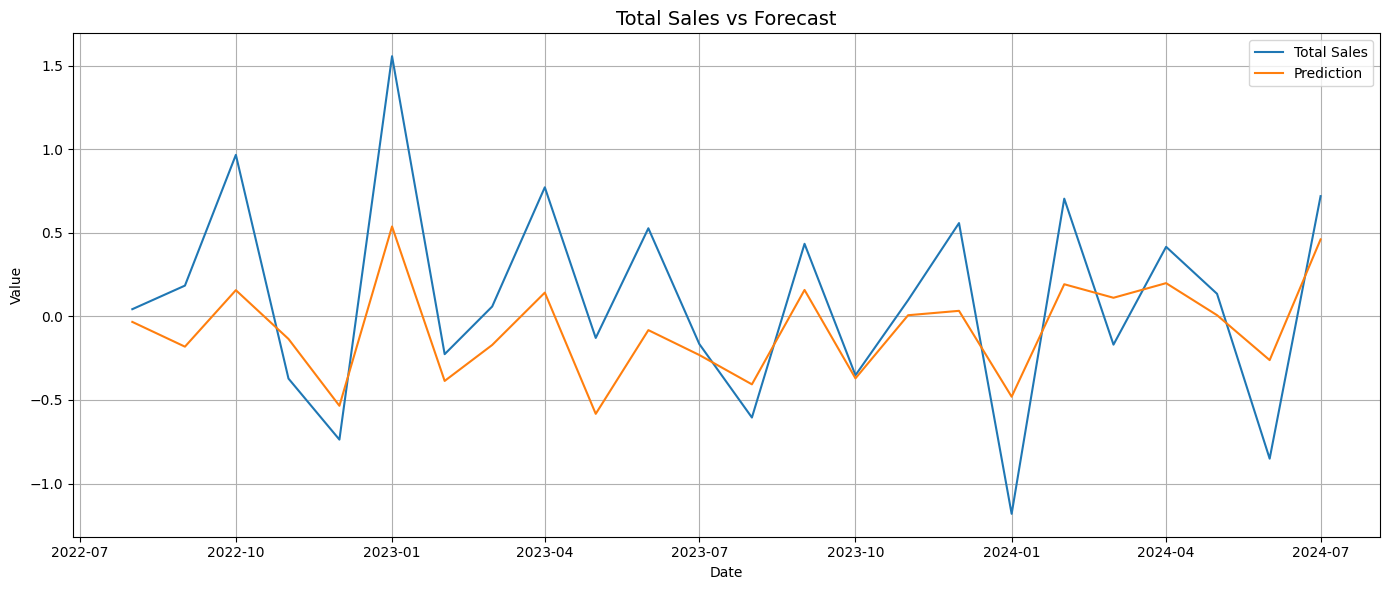

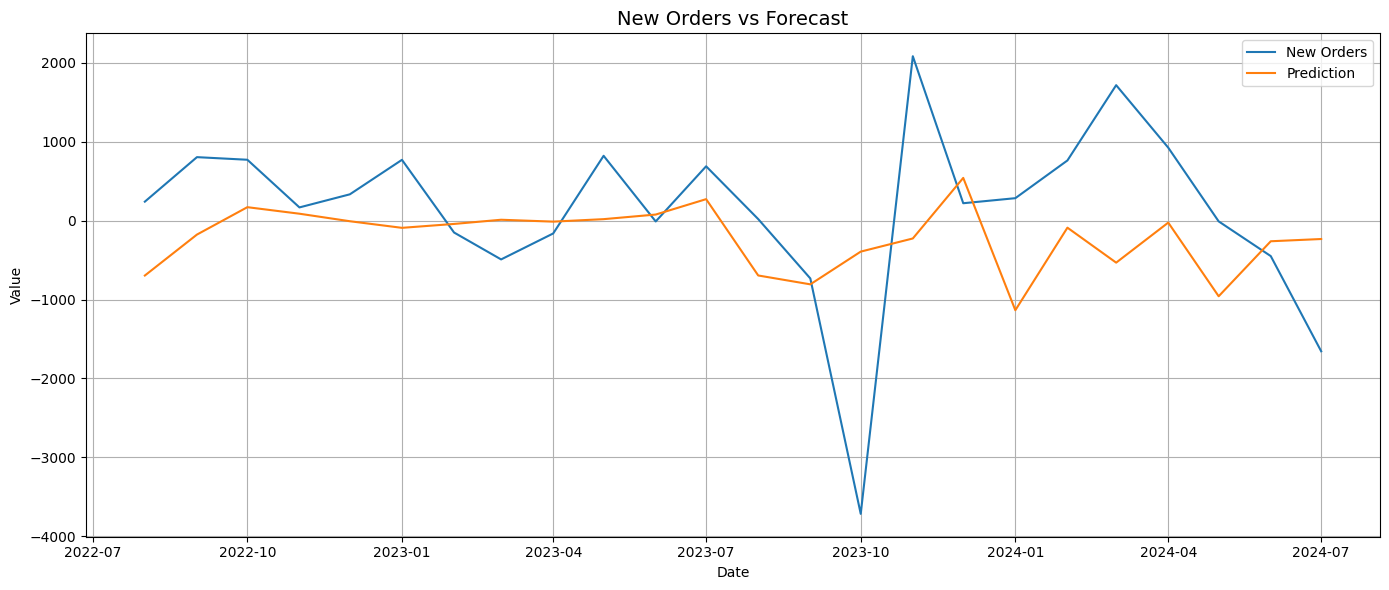

In [98]:
base_varx = train_var(diff_df[['Total Sales', 'New Orders']],  24, exog_data = diff_df[['AISRSA', 'CPI_NewVehicle', 'AUTOSA']])
print('Base Difference VAR')
display(base_varx['metrics'])
for col in ['Total Sales', 'New Orders']:
    df = pd.concat([base_varx['actual'][col], base_varx['pred'][col].rename('Prediction')], axis =1)
    plot_df_subplots(df, overlay =True, title = f'{col} vs Forecast')

In [99]:
# Extract coefficients
coeffs = base_varx['model'].params  # pandas Series with coefficient names
pvals = base_varx['model'].pvalues  # pandas Series with p-values

# Combine into a DataFrame
summary_df = pd.DataFrame({
    "name": coeffs.index,
    "coef": coeffs.values,
    "p_value": pvals.values
})

print(summary_df)

                               name         coef        p_value
0             intercept.Total Sales     0.026630   2.350541e-01
1              intercept.New Orders    21.728333   8.700433e-01
2     L1.e(Total Sales).Total Sales    -0.257346   1.176555e-08
3      L1.e(New Orders).Total Sales     0.000039   5.835164e-05
4     L2.e(Total Sales).Total Sales    -0.215941   4.113828e-06
5      L2.e(New Orders).Total Sales     0.000026   1.058732e-01
6      L1.e(Total Sales).New Orders   360.354592   8.313936e-92
7       L1.e(New Orders).New Orders    -0.064399   1.294080e-01
8      L2.e(Total Sales).New Orders   537.527014   0.000000e+00
9       L2.e(New Orders).New Orders    -0.258795   1.913561e-07
10          beta.AISRSA.Total Sales    -1.018138   4.830747e-10
11  beta.CPI_NewVehicle.Total Sales    -0.076189   1.790418e-03
12          beta.AUTOSA.Total Sales     0.016596   3.414263e-46
13           beta.AISRSA.New Orders -6404.543216   0.000000e+00
14   beta.CPI_NewVehicle.New Orders    9

In [100]:
import pandas as pd

# Example: your regression results as a DataFrame
data = {
    "name": [
        "intercept.Total Sales", "intercept.New Orders",
        "L1.e(Total Sales).Total Sales", "L1.e(New Orders).Total Sales",
        "L2.e(Total Sales).Total Sales", "L2.e(New Orders).Total Sales",
        "L1.e(Total Sales).New Orders", "L1.e(New Orders).New Orders",
        "L2.e(Total Sales).New Orders", "L2.e(New Orders).New Orders",
        "beta.AISRSA.Total Sales", "beta.CPI_NewVehicle.Total Sales", "beta.AUTOSA.Total Sales",
        "beta.AISRSA.New Orders", "beta.CPI_NewVehicle.New Orders", "beta.AUTOSA.New Orders",
        "sqrt.var.Total Sales", "sqrt.cov.Total Sales.New Orders", "sqrt.var.New Orders"
    ],
    "coef": [
        0.026630, 21.728333, -0.257346, 0.000039, -0.215941, 0.000026,
        360.354592, -0.064399, 537.527014, -0.258795, -1.018138, -0.076189, 0.016596,
        -6404.543216, 91.980877, -18.980286, 0.487483, 293.258442, 2427.964839
    ],
    "p_value": [
        2.350541e-01, 8.700433e-01, 1.176555e-08, 5.835164e-05, 4.113828e-06, 1.058732e-01,
        8.313936e-92, 1.294080e-01, 0.0, 1.913561e-07, 4.830747e-10, 1.790418e-03, 3.414263e-46,
        0.0, 7.598420e-03, 6.685619e-05, 7.003649e-262, 7.395380e-02, 1.136719e-243
    ]
}

df = pd.DataFrame(data)

# Split by equation
df['equation'] = df['name'].apply(lambda x: 'Total Sales' if 'Total Sales' in x.split('.')[-1] else 'New Orders')
df['variable'] = df['name'].apply(lambda x: '.'.join(x.split('.')[:-1]))

# Create tables per equation
equations = df['equation'].unique()
tables = {}
for eq in equations:
    tables[eq] = df[df['equation'] == eq][['variable', 'coef', 'p_value']].reset_index(drop=True)

# Print tables
for eq, table in tables.items():
    print(f"\n=== Equation: {eq} ===\n")
    print(table.to_string(index=False))



=== Equation: Total Sales ===

           variable      coef       p_value
          intercept  0.026630  2.350541e-01
  L1.e(Total Sales) -0.257346  1.176555e-08
   L1.e(New Orders)  0.000039  5.835164e-05
  L2.e(Total Sales) -0.215941  4.113828e-06
   L2.e(New Orders)  0.000026  1.058732e-01
        beta.AISRSA -1.018138  4.830747e-10
beta.CPI_NewVehicle -0.076189  1.790418e-03
        beta.AUTOSA  0.016596  3.414263e-46
           sqrt.var  0.487483 7.003649e-262

=== Equation: New Orders ===

            variable         coef       p_value
           intercept    21.728333  8.700433e-01
   L1.e(Total Sales)   360.354592  8.313936e-92
    L1.e(New Orders)    -0.064399  1.294080e-01
   L2.e(Total Sales)   537.527014  0.000000e+00
    L2.e(New Orders)    -0.258795  1.913561e-07
         beta.AISRSA -6404.543216  0.000000e+00
 beta.CPI_NewVehicle    91.980877  7.598420e-03
         beta.AUTOSA   -18.980286  6.685619e-05
sqrt.cov.Total Sales   293.258442  7.395380e-02
            sqrt.

### ARIMAX

#### Setup

In [ ]:
import warnings

# Suppress all FutureWarnings (including the one from statsmodels)
warnings.simplefilter("ignore", FutureWarning)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
def rolling_arimax_forecast(y, exog, horizon, p=3, q=0):
    d = 0
    # Train/test split
    y_train = y.iloc[:-horizon]
    y_test  = y.iloc[-horizon:]
    x_train = exog.iloc[:-horizon]
    x_test  = exog.iloc[-horizon:]

    preds = []
    hist_y = y_train.copy()
    hist_x = x_train.copy()

    # Rolling one-step loop
    for i in range(horizon):
        model = SARIMAX(hist_y, exog=hist_x, order=(p, d, q), trend='n')
        result = model.fit(disp=False, warn_convergence=False)

        # forecast uses NEXT exog row
        next_x = x_test.iloc[i:i+1]
        fc = result.forecast(steps=1, exog=next_x)
        preds.append(fc.iloc[0])

        # update history
        hist_y = pd.concat([hist_y, y_test.iloc[i:i+1]])
        hist_x = pd.concat([hist_x, next_x])

    pred_series = pd.Series(preds, index=y_test.index, name="Prediction")

    forecast = pd.DataFrame({'actuals': y_test, 'predictions': pred_series})

    metrics = {
        "RMSE": mean_squared_error(y_test, pred_series),
        "MAE":  mean_absolute_error(y_test, pred_series)
    }
    return {'model':result,
        "forecast": forecast,
        "metrics": metrics
    }

def rolling_by_dates_test(
    y,
    exog,
    rolling_func,
    cutoff_dates,
    forecast_horizon=1,
    model_params=None
):
    results_dict = {}
    forecasts_dict = {}

    for dt in cutoff_dates:
        if dt not in y.index:
            raise ValueError(f"Cutoff date {dt} not in y index.")
        else: print(f"Predicting based on {dt}")

        window_index = y.index[:y.index.get_loc(dt) + forecast_horizon]
        y_train = y.loc[window_index]
        exog_train = exog.loc[window_index] if exog is not None else None

        # Run your rolling forecast function
        out = rolling_func(
            y_train,
            exog_train,
            horizon=forecast_horizon,
            **(model_params or {})
        )

        forecast = out["forecast"]

        forecasts_dict[dt] = forecast

        results_dict[dt] = out['metrics']

    return pd.DataFrame.from_dict(results_dict, orient="index"), forecasts_dict, out['model']



In [52]:
cutoffs = [
    pd.to_datetime("2006-03-01"),
    pd.to_datetime("2008-03-01"),
    pd.to_datetime("2010-03-01"),
    pd.to_datetime("2012-03-01"),
    pd.to_datetime("2014-03-01"),
    pd.to_datetime("2016-03-01"),
    pd.to_datetime("2018-03-01"),
    pd.to_datetime("2020-03-01"),
    pd.to_datetime("2022-03-01"),
]


#### Total Sales Selection

In [ ]:
p_values = [3,5]
all_results = {}
all_forecasts = {}
for p in p_values:
    print(f"Running ARIMAX with p={p}...")

    results_df, forecasts = rolling_by_dates_test(
        y=diff_df['Total Sales'],
        exog=diff_df[['AISRSA','CPI_NewVehicle','CPI_Used','AUTOSA']],
        rolling_func=rolling_arimax_forecast,
        cutoff_dates=cutoffs,
        forecast_horizon=24,
        model_params={"p":p}
    )
    forecasts["p"] = p
    all_forecasts[p] = forecasts
    results_df["p"] = p 
    all_results[p] = results_df
combined_df = pd.concat(all_results.values(), ignore_index=False).reset_index(drop=False)

combined_forecasts = pd.DataFrame()
for key, forecast in all_forecasts.items():
    temp = pd.concat([forecast[dt] for dt in cutoffs])
    temp['p'] = key
    combined_forecasts = pd.concat([combined_forecasts, temp], ignore_index= False)

metrics = ["MAE", "RMSE"]

display(combined_df.groupby('p')[['MAE', 'RMSE']].mean())
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

for ax, metric in zip(axes, metrics):

    # Pivot so rows = cutoff_date, cols = p, values = metric
    pivot = combined_df.pivot_table(
        index="index", 
        columns="p",
        values=metric
    )

    # Plot each p as a separate line
    pivot.plot(ax=ax, marker="o")

    ax.set_title(f"{metric.upper()} across cutoff dates")
    ax.set_xlabel("Cutoff Date")
    ax.set_ylabel(metric.upper())
    ax.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
actuals = combined_forecasts[combined_forecasts["p"] == p_values[0]]
plt.plot(actuals['actuals'], label = 'Actuals')
for p in p_values:
    sub = combined_forecasts[combined_forecasts["p"] == p]
    plt.plot(sub['predictions'], label = p, alpha = 0.8, linestyle = '--')
plt.title(f"Actuals vs Predictions")
plt.legend()
plt.grid(True)
plt.show()



Running ARIMAX with p=3...
Predicting based on 2006-03-01 00:00:00
Predicting based on 2008-03-01 00:00:00
Predicting based on 2010-03-01 00:00:00
Predicting based on 2012-03-01 00:00:00
Predicting based on 2014-03-01 00:00:00
Predicting based on 2016-03-01 00:00:00
Predicting based on 2018-03-01 00:00:00
Predicting based on 2020-03-01 00:00:00


KeyboardInterrupt: 

#### Total Sales Estimation

Predicting based on 2006-03-01 00:00:00
Predicting based on 2008-03-01 00:00:00
Predicting based on 2010-03-01 00:00:00
Predicting based on 2012-03-01 00:00:00
Predicting based on 2014-03-01 00:00:00
Predicting based on 2016-03-01 00:00:00
Predicting based on 2018-03-01 00:00:00
Predicting based on 2020-03-01 00:00:00
Predicting based on 2022-03-01 00:00:00


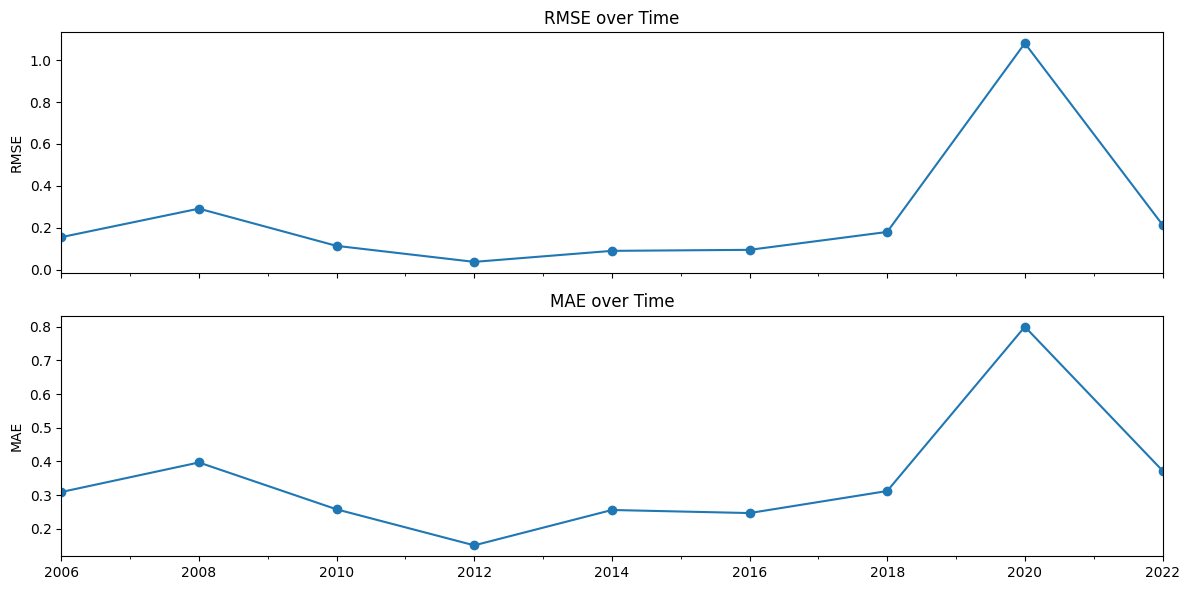

Average RMSE: 0.25045265168992237
Average MAE:  0.34445949008342336


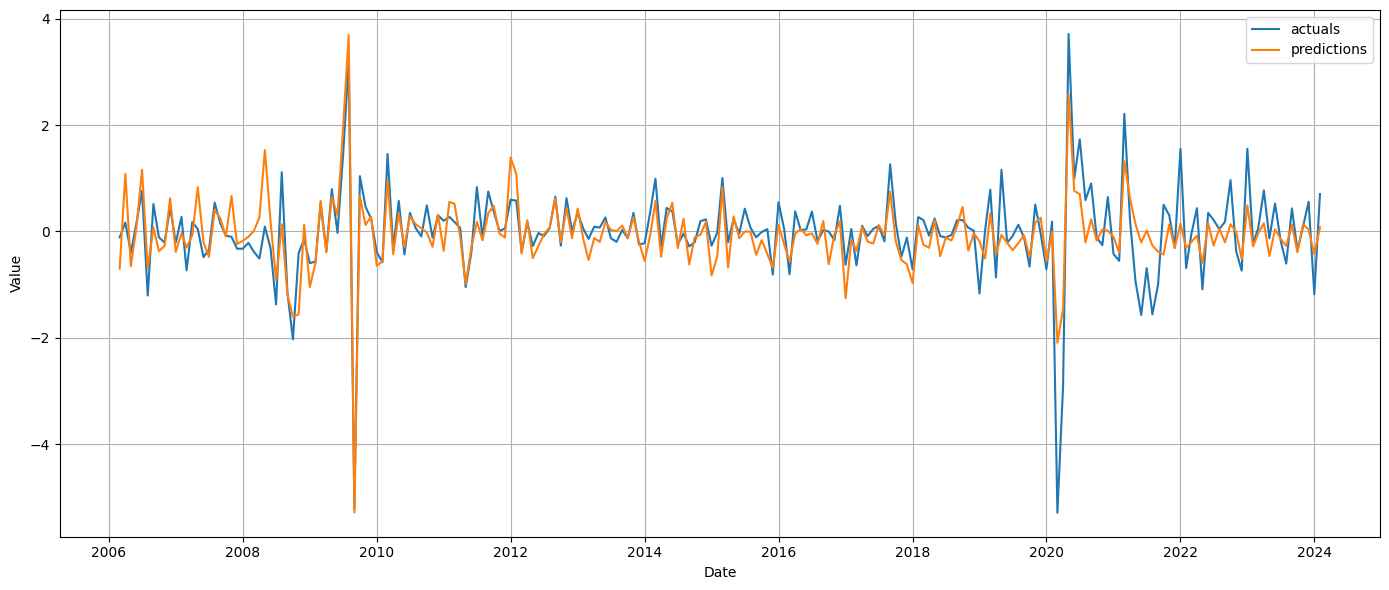

In [93]:
results_df, forecasts, model = rolling_by_dates_test(
    y=diff_df['Total Sales'],
    exog=diff_df[['AISRSA','CPI_NewVehicle','CPI_Used','AUTOSA']],
    rolling_func=rolling_arimax_forecast,
    cutoff_dates=cutoffs,
    forecast_horizon=24,
    model_params={"p":3}
)
# ---- Plot ----
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

results_df["RMSE"].plot(ax=axes[0], marker="o")
axes[0].set_title("RMSE over Time")
axes[0].set_ylabel("RMSE")

results_df["MAE"].plot(ax=axes[1], marker="o")
axes[1].set_title("MAE over Time")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# ---- Averages ----
rmse_avg = results_df["RMSE"].mean()
mae_avg  = results_df["MAE"].mean()

print("Average RMSE:", rmse_avg)
print("Average MAE: ", mae_avg)

combined_forecast = pd.concat([forecasts[dt] for dt in cutoffs])
plot_df_subplots(combined_forecast, True)

In [94]:
coeffs = model.params
pvalues = model.pvalues
summary_df = pd.DataFrame({
    "coef": model.params,
    "p_value": model.pvalues
})
display(summary_df)

,coef,p_value
AISRSA,-0.812143,7.361639e-09
CPI_NewVehicle,-0.064087,6.087761e-02
CPI_Used,-0.000328,9.736943e-01
AUTOSA,0.018251,4.213073e-56
ar.L1,-0.133704,2.411646e-03
ar.L2,-0.130446,3.789680e-03
ar.L3,-0.047707,3.439622e-01
sigma2,0.252787,2.857276e-83


#### New Orders Selection

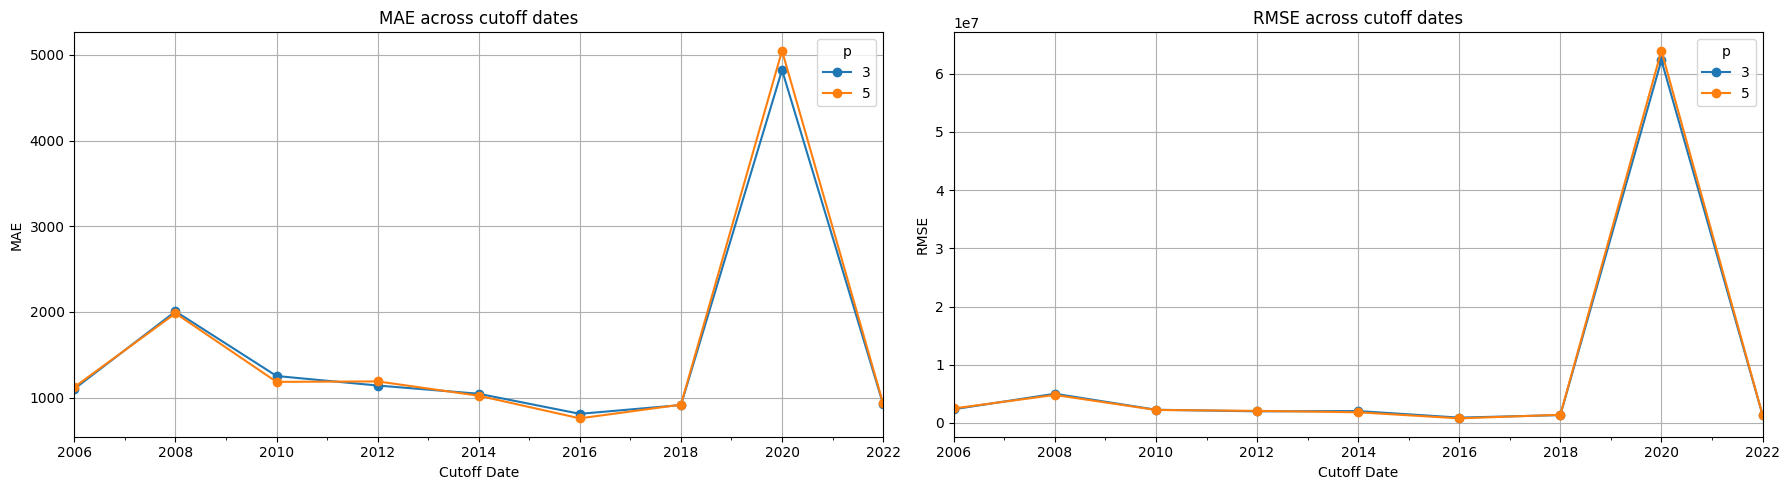

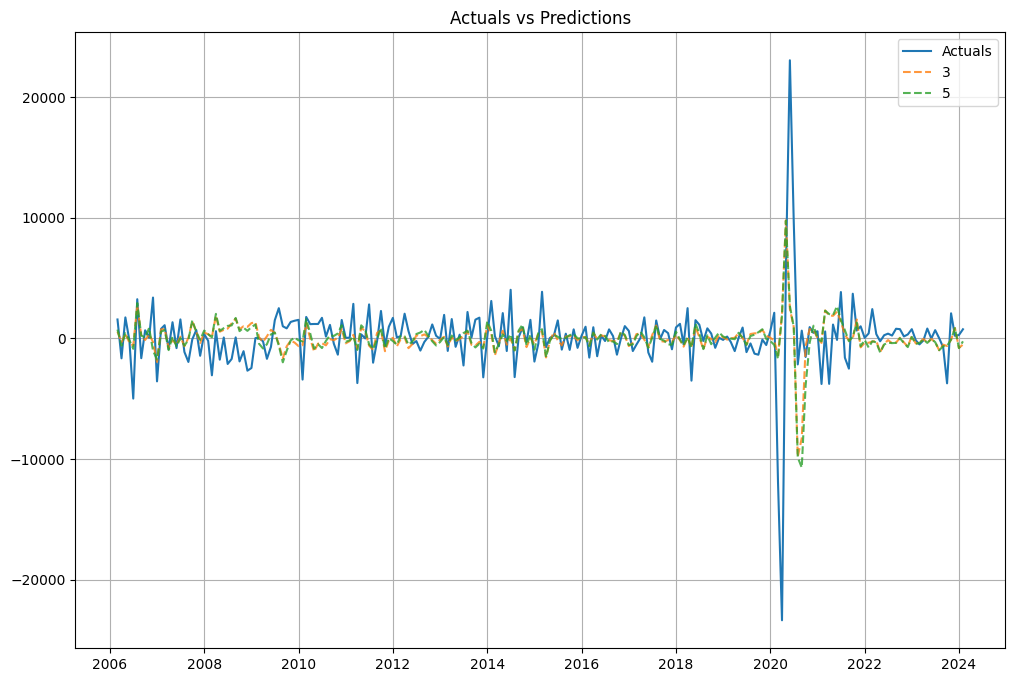

,index,RMSE,MAE,p
0,2006-03-01,2.360060e+06,1103.368630,3
1,2008-03-01,5.020697e+06,2006.485482,3
2,2010-03-01,2.277548e+06,1252.554484,3
3,2012-03-01,2.000837e+06,1141.599340,3
4,2014-03-01,2.049032e+06,1045.512621,3
5,2016-03-01,9.227242e+05,811.352863,3
6,2018-03-01,1.353994e+06,913.513695,3
7,2020-03-01,6.231491e+07,4823.682736,3
8,2022-03-01,1.416334e+06,922.801158,3
9,2006-03-01,2.500965e+06,1123.964636,5


In [ ]:
p_values = [3,5]
all_results = {}  # p → results_df
all_forecasts = {}
for p in p_values:
    print(f"Running ARIMAX with p={p}...")

    results_df, forecasts = rolling_by_dates_test(
        y=diff_df['New Orders'],
        exog=diff_df[['AISRSA']],
        rolling_func=rolling_arimax_forecast,
        cutoff_dates=cutoffs,
        forecast_horizon=24,
        model_params={"p": p}  )
    forecasts["p"] = p
    all_forecasts[p] = forecasts
    results_df["p"] = p 
    all_results[p] = results_df
combined_df = pd.concat(all_results.values(), ignore_index=False).reset_index(drop=False)

combined_forecasts = pd.DataFrame()
for key, forecast in all_forecasts.items():
    temp = pd.concat([forecast[dt] for dt in cutoffs])
    temp['p'] = key
    combined_forecasts = pd.concat([combined_forecasts, temp], ignore_index= False)

metrics = ["MAE", "RMSE"]

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

for ax, metric in zip(axes, metrics):

    # Pivot so rows = cutoff_date, cols = p, values = metric
    pivot = combined_df.pivot_table(
        index="index", 
        columns="p",
        values=metric
    )

    # Plot each p as a separate line
    pivot.plot(ax=ax, marker="o")

    ax.set_title(f"{metric.upper()} across cutoff dates")
    ax.set_xlabel("Cutoff Date")
    ax.set_ylabel(metric.upper())
    ax.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
actuals = combined_forecasts[combined_forecasts["p"] == p_values[0]]
plt.plot(actuals['actuals'], label = 'Actuals')
for p in p_values:
    sub = combined_forecasts[combined_forecasts["p"] == p]
    plt.plot(sub['predictions'], label = p, alpha = 0.8, linestyle = '--')
plt.title(f"Actuals vs Predictions")
plt.legend()
plt.grid(True)
plt.show()
display(combined_df)

#### New Orders Evaluation

Predicting based on 2006-03-01 00:00:00
Predicting based on 2008-03-01 00:00:00
Predicting based on 2010-03-01 00:00:00
Predicting based on 2012-03-01 00:00:00
Predicting based on 2014-03-01 00:00:00
Predicting based on 2016-03-01 00:00:00
Predicting based on 2018-03-01 00:00:00
Predicting based on 2020-03-01 00:00:00
Predicting based on 2022-03-01 00:00:00


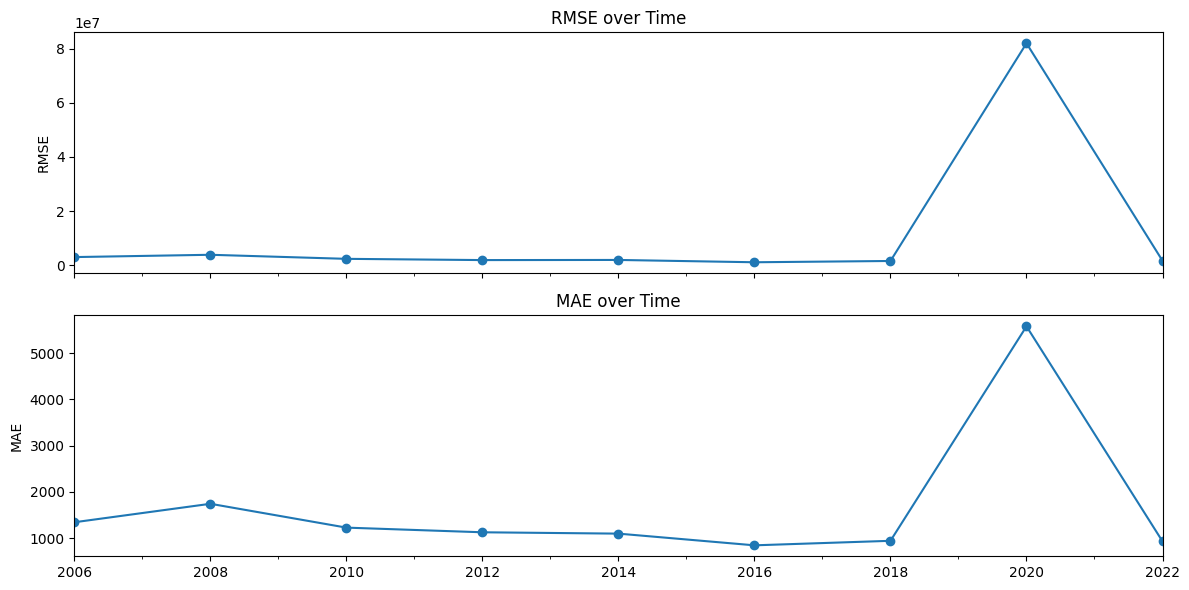

Average RMSE: 11003408.593196003
Average MAE:  1647.0268712508168


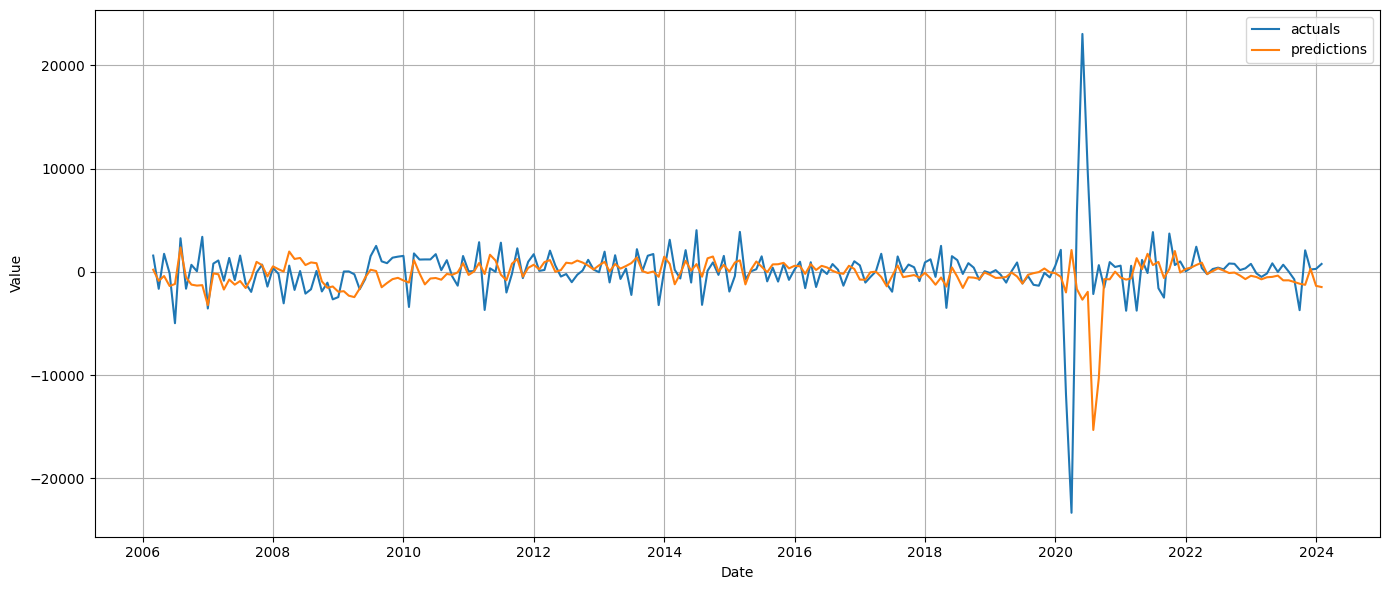

In [95]:
results_df, forecasts, model = rolling_by_dates_test(
    y=diff_df['New Orders'],
    exog=data_df.loc[diff_df.index][['AISRSA', 'FEDFUNDS', 'AUTOSA']],
    rolling_func=rolling_arimax_forecast,
    cutoff_dates=cutoffs,
    forecast_horizon=24,
    model_params={"p": 3}  )

# ---- Plot ----
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

results_df["RMSE"].plot(ax=axes[0], marker="o")
axes[0].set_title("RMSE over Time")
axes[0].set_ylabel("RMSE")

results_df["MAE"].plot(ax=axes[1], marker="o")
axes[1].set_title("MAE over Time")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# ---- Averages ----
rmse_avg = results_df["RMSE"].mean()
mae_avg  = results_df["MAE"].mean()

print("Average RMSE:", rmse_avg)
print("Average MAE: ", mae_avg)

combined_forecast = pd.concat([forecasts[dt] for dt in cutoffs])
plot_df_subplots(combined_forecast, True)

In [96]:
coeffs = model.params
pvalues = model.pvalues
summary_df = pd.DataFrame({
    "coef": model.params,
    "p_value": model.pvalues
})
display(summary_df)

,coef,p_value
AISRSA,-7.862559e+02,3.238465e-16
FEDFUNDS,-1.579900e+02,5.196350e-02
AUTOSA,3.971586e+00,5.303911e-09
ar.L1,9.453491e-02,8.436998e-03
ar.L2,-2.876176e-01,9.399879e-20
ar.L3,-1.254975e-01,5.266622e-04
sigma2,6.243558e+06,1.955729e-69
